In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

'''        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n\n"

In [8]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

In [12]:
eeg_parent_dir = '/kaggle/input/eeg-signal-image/sub-01/sub-01'
eeg_data_train = np.load(os.path.join(eeg_parent_dir,
    'preprocessed_eeg_training.npy'), allow_pickle=True).item()
eeg_data_test = np.load(os.path.join(eeg_parent_dir,
    'preprocessed_eeg_test.npy'), allow_pickle=True).item()

print('Training EEG data shape:')
print(eeg_data_train['preprocessed_eeg_data'].shape)
print('(Training image conditions × Training EEG repetitions × EEG channels × '
    'EEG time points)')

print('\nTest EEG data shape:')
print(eeg_data_test['preprocessed_eeg_data'].shape)
print('(Test image conditions × Test EEG repetitions × EEG channels × '
    'EEG time points)')

print('\nEEG channels:')
for c,chan in enumerate(eeg_data_train['ch_names']):
    print(c, chan)

print('\nEEG time points (in seconds):')
for t,time in enumerate(eeg_data_train['times']):
    print(t, np.round(time, decimals=2))

Training EEG data shape:
(16540, 4, 17, 100)
(Training image conditions × Training EEG repetitions × EEG channels × EEG time points)

Test EEG data shape:
(200, 80, 17, 100)
(Test image conditions × Test EEG repetitions × EEG channels × EEG time points)

EEG channels:
0 Pz
1 P3
2 P7
3 O1
4 Oz
5 O2
6 P4
7 P8
8 P1
9 P5
10 PO7
11 PO3
12 POz
13 PO4
14 PO8
15 P6
16 P2

EEG time points (in seconds):
0 -0.2
1 -0.19
2 -0.18
3 -0.17
4 -0.16
5 -0.15
6 -0.14
7 -0.13
8 -0.12
9 -0.11
10 -0.1
11 -0.09
12 -0.08
13 -0.07
14 -0.06
15 -0.05
16 -0.04
17 -0.03
18 -0.02
19 -0.01
20 0.0
21 0.01
22 0.02
23 0.03
24 0.04
25 0.05
26 0.06
27 0.07
28 0.08
29 0.09
30 0.1
31 0.11
32 0.12
33 0.13
34 0.14
35 0.15
36 0.16
37 0.17
38 0.18
39 0.19
40 0.2
41 0.21
42 0.22
43 0.23
44 0.24
45 0.25
46 0.26
47 0.27
48 0.28
49 0.29
50 0.3
51 0.31
52 0.32
53 0.33
54 0.34
55 0.35
56 0.36
57 0.37
58 0.38
59 0.39
60 0.4
61 0.41
62 0.42
63 0.43
64 0.44
65 0.45
66 0.46
67 0.47
68 0.48
69 0.49
70 0.5
71 0.51
72 0.52
73 0.53
74 0.54
7

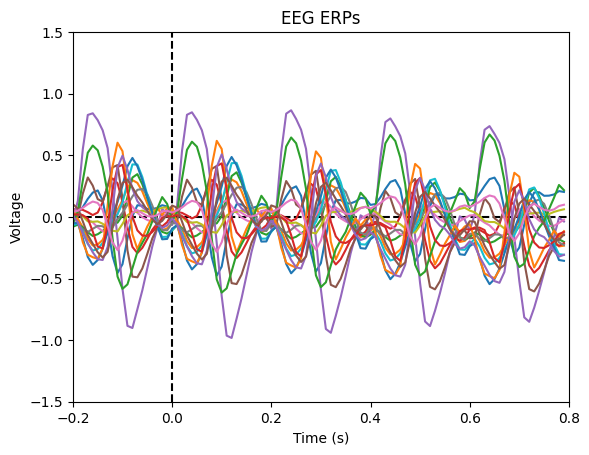

In [13]:
erp_data_train = np.mean(eeg_data_train['preprocessed_eeg_data'], 1)
erp_data_test = np.mean(eeg_data_test['preprocessed_eeg_data'], 1)
erp_data_all = np.mean(np.append(erp_data_train, erp_data_test, 0), 0)

plt.figure()
plt.plot([-.2, .8], [0, 0], 'k--', [0, 0], [-1.5, 1.5], 'k--')
plt.plot(eeg_data_train['times'], np.transpose(erp_data_all));
plt.xlabel('Time (s)');
plt.xlim(left=-.2, right=.8)
plt.ylabel('Voltage');
plt.ylim(bottom=-1.5, top=1.5)
plt.title('EEG ERPs');

In [14]:
img_parent_dir  = '/kaggle/input/eeg-signal-image/osfstorage-archive/training_images'
img_metadata = np.load('/kaggle/input/eeg-signal-image/osfstorage-archive/image_metadata.npy',
	allow_pickle=True).item()

n_train_img = len(img_metadata['train_img_concepts'])
n_train_concepts = len(np.unique(img_metadata['train_img_concepts']))
n_train_img_per_concept = int(n_train_img / n_train_concepts)
print('Training images: ' + str(n_train_img))
print('Image concepts: ' + str(n_train_concepts))
print('Images per concept: '+ str(n_train_img_per_concept))

n_test_img = len(img_metadata['test_img_concepts'])
n_test_concepts = len(np.unique(img_metadata['test_img_concepts']))
n_test_img_per_concept = int(n_test_img / n_test_concepts)
print('\nTest images: ' + str(n_test_img))
print('Image concepts: ' + str(n_test_concepts))
print('Images per concept: '+ str(n_test_img_per_concept))

Training images: 16540
Image concepts: 1654
Images per concept: 10

Test images: 200
Image concepts: 200
Images per concept: 1


Training EEG single image data shape:
(4, 17, 100)
(Training EEG repetitions × EEG channels × EEG time points)



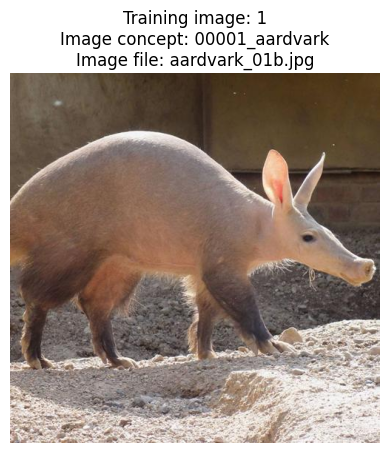

In [15]:
train_img_idx =  0 #@param {type:"integer"}

eeg_data_single_image = eeg_data_train['preprocessed_eeg_data'][train_img_idx]
print('Training EEG single image data shape:')
print(eeg_data_single_image.shape)
print('(Training EEG repetitions × EEG channels × EEG time points)\n')

train_img_dir = os.path.join(img_parent_dir, 'training_images',
	img_metadata['train_img_concepts'][train_img_idx],
	img_metadata['train_img_files'][train_img_idx])
train_img = Image.open(train_img_dir).convert('RGB')

plt.figure()
plt.axis('off')
plt.imshow(train_img)
plt.title('Training image: ' + str(train_img_idx+1) + '\nImage concept: ' +\
	img_metadata['train_img_concepts'][train_img_idx] + '\nImage file: ' +\
	img_metadata['train_img_files'][train_img_idx]);

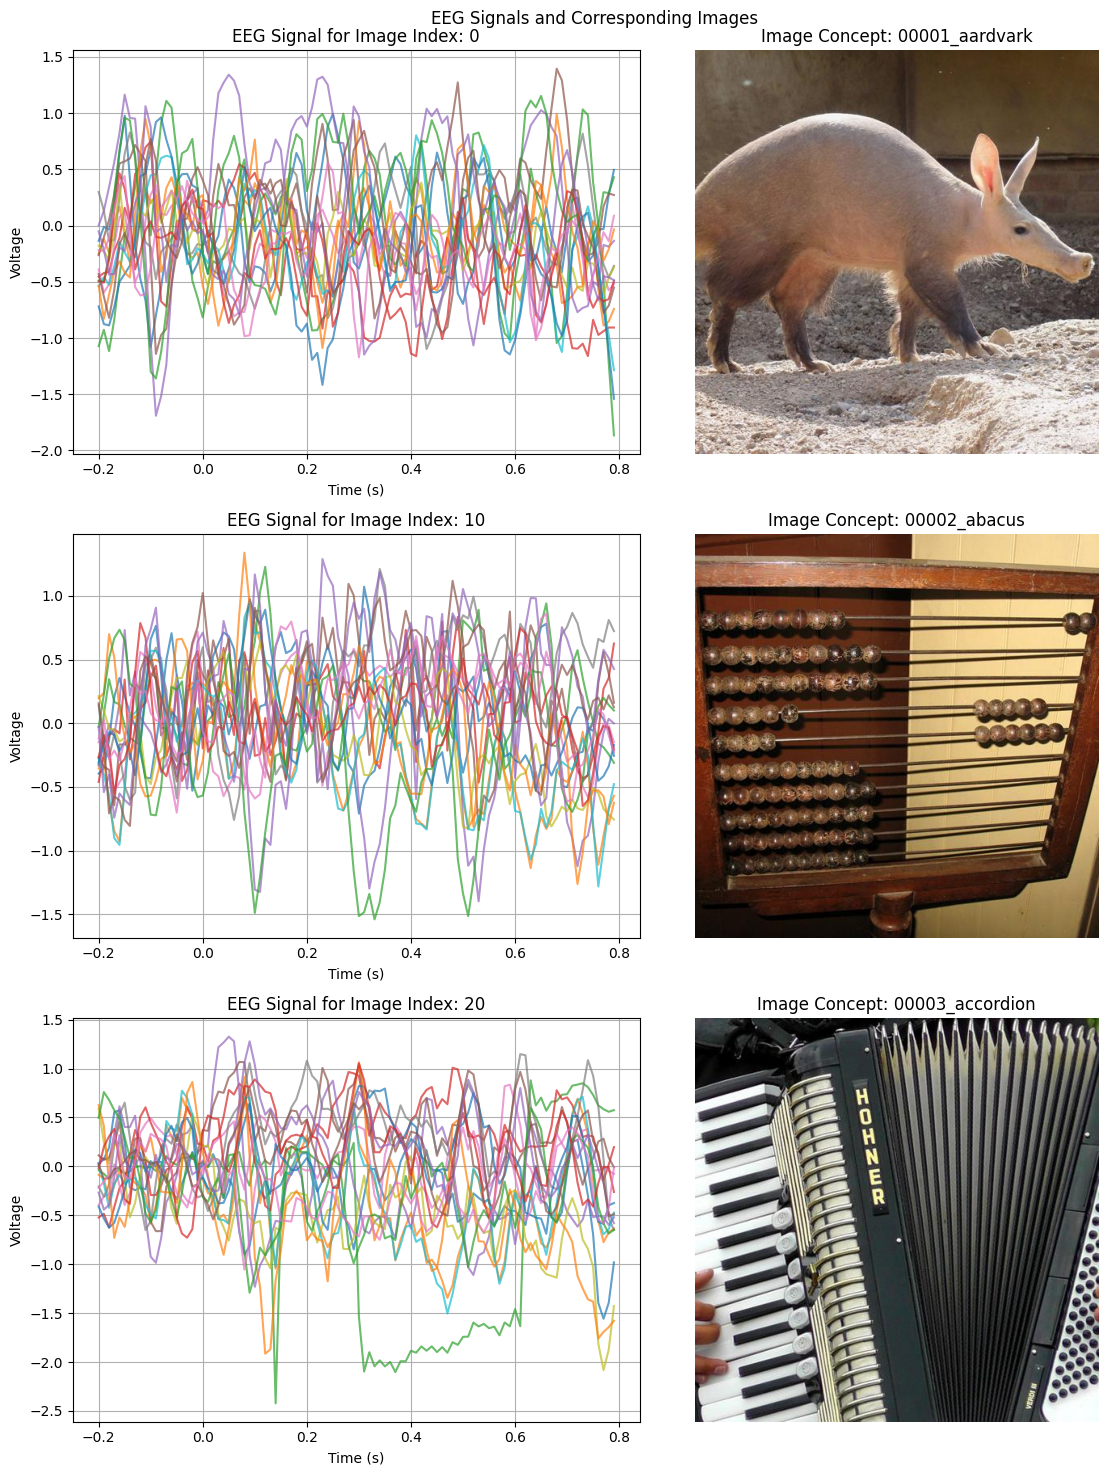

In [35]:
## Plotting EEG and Image Side by Side

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Function to plot EEG signals and corresponding images for multiple samples
def plot_multiple_eeg_and_images(eeg_data, times, images, metadata, indices, title="EEG and Images"):
    fig, axes = plt.subplots(len(indices), 2, figsize=(12, 5 * len(indices)))

    for i, idx in enumerate(indices):
        # Extract EEG data for the given index
        eeg_signal = np.mean(eeg_data['preprocessed_eeg_data'][idx], axis=0)  # Average repetitions
        img_path = os.path.join(
            img_parent_dir, 
            'training_images',
            metadata['train_img_concepts'][idx],
            metadata['train_img_files'][idx]
        )
        img = Image.open(img_path).convert('RGB')

        # Plot EEG signal
        axes[i, 0].plot(times, eeg_signal.T, alpha=0.7)
        axes[i, 0].set_title(f"EEG Signal for Image Index: {idx}")
        axes[i, 0].set_xlabel("Time (s)")
        axes[i, 0].set_ylabel("Voltage")
        axes[i, 0].grid(True)

        # Plot image
        axes[i, 1].imshow(img)
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"Image Concept: {metadata['train_img_concepts'][idx]}")

    # Overall title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example usage
indices_to_plot = [0, 10, 20]  # Change these to any indices you want to visualize
plot_multiple_eeg_and_images(
    eeg_data=eeg_data_train, 
    times=eeg_data_train['times'], 
    images=img_metadata['train_img_files'], 
    metadata=img_metadata, 
    indices=indices_to_plot,
    title="EEG Signals and Corresponding Images"
)



GETTING EMBEDDINGS FROM EEG USING VARIATIONAL AUTO ENCODER

In [17]:
import tensorflow as tf

# Check GPU availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available and being used.")
    print(tf.config.list_physical_devices('GPU'))
else:
    print("No GPU detected. Please ensure GPU runtime is enabled.")

GPU is available and being used.
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [32]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler

# Load EEG data
eeg_parent_dir = '/kaggle/input/eeg-signal-image/sub-01/sub-01'
eeg_data_train = np.load(os.path.join(eeg_parent_dir, 'preprocessed_eeg_training.npy'), allow_pickle=True).item()

# Preprocess EEG data
eeg_data = np.mean(eeg_data_train['preprocessed_eeg_data'], axis=1)  # Average repetitions
eeg_flattened = eeg_data.reshape(eeg_data.shape[0], -1)  # Flatten (images × (channels × time points))

# Standardize the data
scaler = StandardScaler()
eeg_standardized = scaler.fit_transform(eeg_flattened)

# Define VAE components
latent_dim = 50  # Size of the embedding

# Encoder
input_eeg = layers.Input(shape=(eeg_standardized.shape[1],), name="encoder_input")
x = layers.Dense(128, activation='relu')(input_eeg)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# Reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], latent_dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Decoder
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(128, activation='relu')(decoder_input)
decoder_output = layers.Dense(eeg_standardized.shape[1], activation='sigmoid')(x)

# Models
encoder = Model(input_eeg, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, decoder_output, name='decoder')

# Full VAE Model
vae_output = decoder(z)
vae = Model(input_eeg, vae_output, name='vae')


In [21]:
print(f"EEG standardized shape: {eeg_standardized.shape}")

EEG standardized shape: (16540, 1700)


In [23]:
input_eeg = layers.Input(shape=(eeg_standardized.shape[1],), name="encoder_input")
print(input_eeg)

<KerasTensor shape=(None, 1700), dtype=float32, sparse=None, name=encoder_input>


In [30]:
# Check the shape of eeg_standardized
print("eeg_standardized shape:", eeg_standardized.shape)

# Define VAE loss
def reconstruction_loss_fn(y_true, y_pred):
    # Check shapes of y_true and y_pred
    print("Reconstruction loss shapes:", y_true.shape, y_pred.shape)
    return tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)

def kl_loss_fn(z_mean, z_log_var):
    # Check shapes of z_mean and z_log_var
    print("KL loss shapes:", z_mean.shape, z_log_var.shape)
    return -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)

class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    @tf.function
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Replace NaNs in reconstruction
            reconstruction = tf.where(tf.math.is_nan(reconstruction), tf.zeros_like(reconstruction), reconstruction)

            # Compute per-sample reconstruction loss (reduce over features)
            reconstruction_loss = tf.reduce_mean(tf.square(data - reconstruction), axis=1)  # Shape: (batch_size,)

            # Compute per-sample KL loss (reduce over latent dimensions)
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)  # Shape: (batch_size,)

            # Combine losses
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)  # Aggregate over the batch

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Return losses for logging
        return {
            "loss": total_loss,
            "reconstruction_loss": tf.reduce_mean(reconstruction_loss),  # Log mean reconstruction loss
            "kl_loss": tf.reduce_mean(kl_loss),  # Log mean KL loss
        }

# Compile and train the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')

# Verify NaNs in the data
print("NaNs in EEG data:", np.isnan(eeg_standardized).any())

# Train the VAE
vae.fit(eeg_standardized, epochs=50, batch_size=32)

eeg_standardized shape: (16540, 1700)
NaNs in EEG data: False
Epoch 1/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - kl_loss: 0.0101 - loss: 1.0001 - reconstruction_loss: 0.9900
Epoch 2/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 0.0079 - loss: 0.9970 - reconstruction_loss: 0.9890
Epoch 3/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 0.0081 - loss: 0.9967 - reconstruction_loss: 0.9887
Epoch 4/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 0.0080 - loss: 0.9978 - reconstruction_loss: 0.9898
Epoch 5/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 0.0081 - loss: 0.9972 - reconstruction_loss: 0.9891
Epoch 6/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 0.0081 - loss: 0.9969 - reconstruction_loss: 0.9888
Epoch 7/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 0.0081 - loss: 0.9972 - reconstruction_loss: 0.9892
Epoch 8/50
517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 0.0081 - loss: 0.9971 - reconstruction_loss: 0.9890
Epoch 9/50
517/517

In [58]:
# Extract embeddings
eeg_embeddings = encoder.predict(eeg_standardized)

# Save embeddings
np.save('eeg_embeddings.npy', eeg_embeddings)
#print(eeg_embeddings)

print(len(eeg_embeddings))

517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
3


In [49]:
encoder.save('vae_encoder.h5')
decoder.save('vae_decoder.h5')

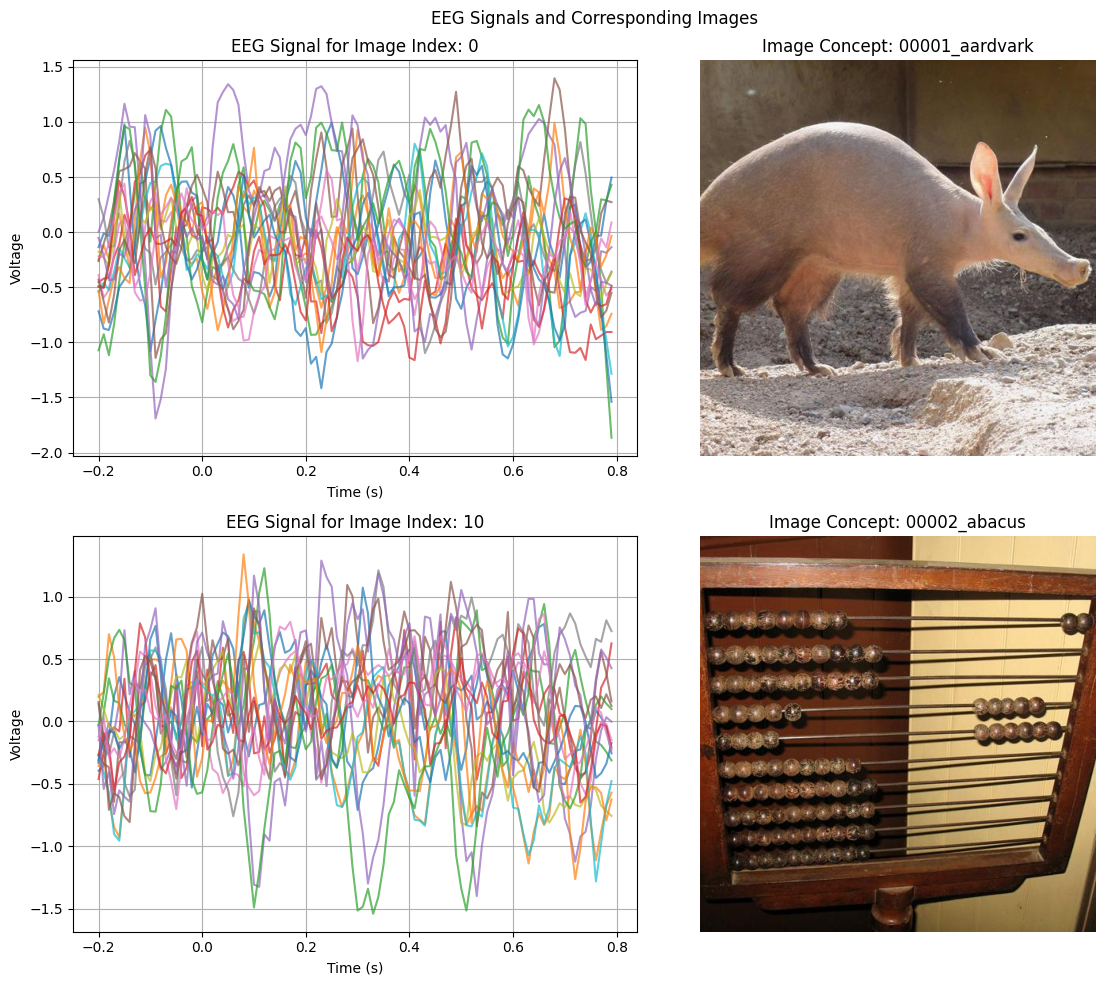

In [39]:
## Plotting EEG and Image Side by Side

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Function to plot EEG signals and corresponding images for multiple samples
def plot_multiple_eeg_and_images(eeg_data, times, images, metadata, indices, title="EEG and Images"):
    fig, axes = plt.subplots(len(indices), 2, figsize=(12, 5 * len(indices)))

    for i, idx in enumerate(indices):
        # Extract EEG data for the given index
        eeg_signal = np.mean(eeg_data['preprocessed_eeg_data'][idx], axis=0)  # Average repetitions
        img_path = os.path.join(
            img_parent_dir, 
            'training_images',
            metadata['train_img_concepts'][idx],
            metadata['train_img_files'][idx]
        )
        img = Image.open(img_path).convert('RGB')

        # Plot EEG signal
        axes[i, 0].plot(times, eeg_signal.T, alpha=0.7)
        axes[i, 0].set_title(f"EEG Signal for Image Index: {idx}")
        axes[i, 0].set_xlabel("Time (s)")
        axes[i, 0].set_ylabel("Voltage")
        axes[i, 0].grid(True)

        # Plot image
        axes[i, 1].imshow(img)
        axes[i, 1].axis("off")
        axes[i, 1].set_title(f"Image Concept: {metadata['train_img_concepts'][idx]}")

    # Overall title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example usage
indices_to_plot = [0, 10]  # Change these to any indices you want to visualize
plot_multiple_eeg_and_images(
    eeg_data=eeg_data_train, 
    times=eeg_data_train['times'], 
    images=img_metadata['train_img_files'], 
    metadata=img_metadata, 
    indices=indices_to_plot,
    title="EEG Signals and Corresponding Images"
)



In [46]:
print((eeg_standardized)[2].shape)

(1700,)


In [59]:
from tensorflow.keras.models import load_model

eeg_embeddings_test_1 = encoder.predict(eeg_standardized)[0]

np.save('eeg_embeddings_test_1.npy', eeg_embeddings_test_1)
print(len(eeg_embeddings_test_1))

517/517 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
16540
